##sample

prerocessing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/flight_lstm_data.csv")

# Check for missing values
print(df.isnull().sum())

# Select columns to scale
columns_to_scale = ["Altitude_ft", "Airspeed_knots", "Vertical_Speed_ftmin",
                    "Pitch_Angle_deg", "Roll_Angle_deg", "Engine_Power_%"]

# Save the original min/max values before scaling
original_min = df["Vertical_Speed_ftmin"].min()
original_max = df["Vertical_Speed_ftmin"].max()

# Normalize flight parameters
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Save the scaler for later use
joblib.dump(scaler, "scaler.pkl")

print(df.head())  # Check the preprocessed data


Time_Step               0
Altitude_ft             0
Airspeed_knots          0
Vertical_Speed_ftmin    0
Pitch_Angle_deg         0
Roll_Angle_deg          0
Engine_Power_%          0
Flap_Position           0
Gear_Position           0
dtype: int64
   Time_Step  Altitude_ft  Airspeed_knots  Vertical_Speed_ftmin  \
0          0     0.133848        0.168248              0.312571   
1          1     0.132770        0.189954              0.178117   
2          2     0.137821        0.460834              0.859225   
3          3     0.149699        0.286336              0.403459   
4          4     0.147873        0.247504              0.398479   

   Pitch_Angle_deg  Roll_Angle_deg  Engine_Power_%  Flap_Position  \
0         0.344542        0.686297        0.851595              0   
1         0.349799        0.022283        0.235451              0   
2         0.542951        0.054013        0.599775              1   
3         0.383384        0.532838        0.856101              0   
4    

In [ ]:
# Convert 300 and -300 ft/min into normalized values using the saved original values
#climb_threshold = scaler.transform([[0, 0, 500, 0, 0, 0]])[0][2]  # Get the scaled value for 300 ft/min
#descent_threshold = scaler.transform([[0, 0, -500, 0, 0, 0]])[0][2]  # Get the scaled value for -300 ft/min


Identify Flight Regimes

In [ ]:
# Create DataFrame with the same column names for transformation
sample_df = pd.DataFrame([[0, 0, 500, 0, 0, 0]], columns=columns_to_scale)
climb_threshold = scaler.transform(sample_df)[0][2]

sample_df = pd.DataFrame([[0, 0, -500, 0, 0, 0]], columns=columns_to_scale)
descent_threshold = scaler.transform(sample_df)[0][2]


def classify_flight_regime(row):
    if row["Vertical_Speed_ftmin"] > climb_threshold:
        return "Climb"
    elif row["Vertical_Speed_ftmin"] < descent_threshold:
        return "Descent"
    else:
        return "Cruise"

df["Flight_Regime"] = df.apply(classify_flight_regime, axis=1)

print(df["Flight_Regime"].value_counts())  # Verify if we now get Climb and Descent


Flight_Regime
Descent    1894
Climb      1864
Cruise     1242
Name: count, dtype: int64


Convert Data into Sequences for LSTM

In [ ]:
import numpy as np
#Create sequences for LSTM
def create_sequences(data, sequence_length=50):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# Select only numerical columns for LSTM input
features = df[columns_to_scale].values
sequences = create_sequences(features)

print("Shape of sequences:", sequences.shape)  # (num_samples, sequence_length, num_features)



Shape of sequences: (4950, 50, 6)


##data collection and preprocessing

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/train_dataset/NGAFID_MC_C37.csv', nrows=56)
print(df.columns)
print(len(df.columns))  # Check the total count

Index(['volt1', 'volt2', 'amp1', 'amp2', 'FQtyL', 'FQtyR', 'E1 FFlow',
       'E1 OilT', 'E1 OilP', 'E1 RPM', 'E1 CHT1', 'E1 CHT2', 'E1 CHT3',
       'E1 CHT4', 'E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4', 'OAT', 'IAS',
       'VSpd', 'NormAc', 'AltMSL', 'id', 'plane_id', 'split', 'date_diff',
       'before_after'],
      dtype='object')
28


In [ ]:
import pandas as pd

chunk_size = 10000  # Number of rows per chunk
for chunk in pd.read_csv('/content/drive/MyDrive/train_dataset/NGAFID_MC_C37.csv', chunksize=chunk_size):
    # Process each chunk
    print(chunk)


Streaming output truncated to the last 5000 lines.
          volt1  volt2  amp1  amp2  FQtyL  FQtyR  E1 FFlow  E1 OilT  E1 OilP  \
12170000   28.0   28.0   1.1  -0.0  20.42  24.00      8.56    149.8    71.10   
12170001   28.0   28.0   1.1  -0.1  20.42  24.00      8.55    149.6    70.70   
12170002   28.0   28.0   1.0  -0.1  20.42  24.00      8.57    149.6    71.06   
12170003   28.0   28.0   0.9  -0.1  20.42  24.00      8.52    149.6    70.80   
12170004   28.1   28.1   1.0  -0.1  20.39  24.00      8.51    149.5    70.60   
...         ...    ...   ...   ...    ...    ...       ...      ...      ...   
12179995   28.3   28.3   1.1  -0.1  17.44  16.38      8.15    170.2    65.20   
12179996   28.3   28.3   1.1  -0.1  17.38  16.40      8.49    170.2    66.00   
12179997   28.3   28.3   1.1  -0.0  17.30  16.45      9.83    170.2    66.90   
12179998   28.3   28.3   1.1  -0.1  17.16  16.62      9.86    170.4    67.50   
12179999   28.3   28.3   1.1  -0.1  17.20  16.56     10.10    170.4  

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/train_dataset/NGAFID_MC_C28.csv', nrows=56)
print(df.columns)
print(len(df.columns))  # Check the total count

Index(['volt1', 'volt2', 'amp1', 'amp2', 'FQtyL', 'FQtyR', 'E1 FFlow',
       'E1 OilT', 'E1 OilP', 'E1 RPM', 'E1 CHT1', 'E1 CHT2', 'E1 CHT3',
       'E1 CHT4', 'E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4', 'OAT', 'IAS',
       'VSpd', 'NormAc', 'AltMSL', 'id', 'plane_id', 'split', 'date_diff',
       'before_after'],
      dtype='object')
28


In [ ]:
import pandas as pd

chunk_size = 10000  # Number of rows per chunk
for chunk in pd.read_csv('/content/drive/MyDrive/train_dataset/NGAFID_MC_C28.csv', chunksize=chunk_size):
    # Process each chunk
    print(chunk)


Streaming output truncated to the last 5000 lines.
          volt1  volt2  amp1  amp2  FQtyL  FQtyR  E1 FFlow  E1 OilT  E1 OilP  \
27540000   28.7    NaN   1.2   NaN  27.98  31.48      2.07    150.2    61.34   
27540001   28.7    NaN   1.1   NaN  28.50  31.48      1.74    150.9    60.88   
27540002   28.7    NaN   0.8   NaN  28.89  32.10      1.50    151.4    59.70   
27540003   28.7    NaN   0.9   NaN  29.02  32.44      1.39    151.8    58.75   
27540004   28.7    NaN   1.0   NaN  29.81  31.94      1.27    152.0    57.47   
...         ...    ...   ...   ...    ...    ...       ...      ...      ...   
27549995   28.0   28.1   1.3  -0.0  20.12  22.80     10.61    184.0    69.00   
27549996   28.0   28.1   1.6   0.0  20.17  22.70     10.62    184.1    69.10   
27549997   28.0   28.1   1.5   0.0  20.17  22.70     10.52    184.1    69.25   
27549998   28.0   28.0   1.2   0.0  20.12  22.70     10.62    184.2    68.80   
27549999   28.0   28.0   1.2  -0.0  20.17  22.70     10.55    184.4  

In [ ]:
import pandas as pd

# Load datasets
df1 = pd.read_csv("/content/drive/MyDrive/train_dataset/NGAFID_MC_C28.csv")  # First CSV
df2 = pd.read_csv("/content/drive/MyDrive/train_dataset/NGAFID_MC_C37.csv")  # Second CSV

# Merge datasets (change axis=0 or axis=1 based on your need)
df = pd.concat([df1, df2], axis=0, ignore_index=True)  # Merge by stacking rows

# Select relevant columns
selected_columns = [
    "Altitude_ft", "Airspeed_knots", "Vertical_Speed_ftmin",
    "Pitch_Angle_deg", "Roll_Angle_deg", "Heading_deg",
    "Engine_Power_%", "E1 RPM", "E1 OilP", "E1 OilT", "E1 FFlow",
    "OAT", "NormAc", "IAS", "AltMSL", "VSpd", "FQtyL", "FQtyR",
    "plane_id", "split", "WOW", "Latitude", "Longitude"
]

# Check for missing columns
available_columns = [col for col in selected_columns if col in df.columns]
missing_columns = [col for col in selected_columns if col not in df.columns]

if missing_columns:
    print("Warning: The following columns are missing:", missing_columns)

df_reduced = df[available_columns]

# Reduce dataset to 1000 rows (randomly)
df_reduced_10 = df_reduced.sample(n=10, random_state=42)

# Save to CSV
df_reduced_10.to_csv("small_flight_data.csv", index=False)
print("Reduced dataset saved! Shape:", df_reduced_10.shape)



In [ ]:
import pandas as pd

use_columns = [
    "Altitude_ft", "Airspeed_knots", "Vertical_Speed_ftmin",
    "Pitch_Angle_deg", "Roll_Angle_deg", "Heading_deg",
    "Engine_Power_%", "E1 RPM", "E1 OilP", "E1 OilT", "E1 FFlow",
    "OAT", "NormAc", "IAS", "AltMSL", "VSpd", "FQtyL", "FQtyR",
    "plane_id", "split", "WOW", "Latitude", "Longitude"
]

# Load in very small chunks
chunk_size = 1000
df_chunks = pd.read_csv("/content/drive/MyDrive/train_dataset/NGAFID_MC_C28.csv", usecols=use_columns, chunksize=chunk_size)

df_list = []
for chunk in df_chunks:
    chunk = chunk.astype("float16", errors="ignore")  # Reduce memory usage
    df_list.append(chunk)

df_reduced = pd.concat(df_list[:10], axis=0)  # Use only 10,000 rows to save RAM
df_reduced.to_csv("small_flight_data.csv", index=False)

print(" Small dataset saved! Shape:", df_reduced.shape)



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/train_dataset/NGAFID_MC_C28.csv'

In [ ]:
import pandas as pd

# Define the available columns (common in both CSVs)
use_columns = [
    "volt1", "volt2", "amp1", "amp2", "FQtyL", "FQtyR",
    "E1 FFlow", "E1 OilT", "E1 OilP", "E1 RPM",
    "OAT", "IAS", "VSpd", "NormAc", "AltMSL",
    "plane_id", "split"
]

# Read both CSVs in chunks to avoid memory crashes
chunk_size = 5000

df_chunks1 = pd.read_csv("/content/drive/MyDrive/debrief/NGAFID_MC_C28-001.csv", usecols=use_columns, chunksize=chunk_size)
df_chunks2 = pd.read_csv("/content/drive/MyDrive/debrief/NGAFID_MC_C37.csv", usecols=use_columns, chunksize=chunk_size)

# Convert chunks into full DataFrames
df1 = pd.concat(df_chunks1, ignore_index=True)
df2 = pd.concat(df_chunks2, ignore_index=True)

# Merge both datasets
df_combined = pd.concat([df1, df2], axis=0)

# Reduce to 1000 rows randomly
df_reduced_1000 = df_combined.sample(n=1000, random_state=42)

# Save to CSV
df_reduced_1000.to_csv("small_flight_data.csv", index=False)
print("Reduced dataset saved with shape:", df_reduced_1000.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/debrief/NGAFID_MC_C28-001.csv'

##start here

In [ ]:
import pandas as pd

# Define the dataset path
file_path1 = "/content/drive/MyDrive/train_dataset/NGAFID_MC_C28.csv"
file_path2 = "/content/drive/MyDrive/train_dataset/NGAFID_MC_C37.csv"

# Define important columns available in the dataset
selected_columns = [
    "AltMSL", "IAS", "VSpd", "NormAc", "FQtyL", "FQtyR",
    "E1 FFlow", "E1 OilT", "E1 OilP", "E1 RPM", "OAT",
    "plane_id", "split"
]

# Load a small sample from each CSV
chunk_size = 5000  # Load in small parts to avoid memory issues
df_sample1 = pd.read_csv(file_path1, usecols=selected_columns, nrows=500)
df_sample2 = pd.read_csv(file_path2, usecols=selected_columns, nrows=500)

# Combine both samples
df_small = pd.concat([df_sample1, df_sample2], ignore_index=True)

# Save the reduced dataset
df_small.to_csv("sample_flight_data.csv", index=False)
print("Sample dataset saved with shape:", df_small.shape)


Sample dataset saved with shape: (1000, 13)


check for missing value

In [ ]:
print(df_small.isnull().sum())  # Check for NaN values
df_small.dropna(inplace=True)   # Remove rows with missing values (if any)


FQtyL       0
FQtyR       0
E1 FFlow    0
E1 OilT     0
E1 OilP     0
E1 RPM      0
OAT         0
IAS         0
VSpd        0
NormAc      0
AltMSL      2
plane_id    0
split       0
dtype: int64


Removing Missing Rows

In [ ]:
df_small.dropna(inplace=True)


Normalize data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_small), columns=df_small.columns)


converting data into sequence

In [ ]:
import numpy as np

def create_sequences(data, sequence_length=50):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 50  # Choose a sequence length (e.g., past 50 time steps)
features = df_scaled.values
sequences = create_sequences(features, sequence_length)

print("LSTM input shape:", sequences.shape)  # (samples, sequence_length, features)


LSTM input shape: (948, 50, 13)


test train split

In [ ]:
train_size = int(len(sequences) * 0.8)  # 80% for training
train_data = sequences[:train_size]
test_data = sequences[train_size:]

print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)


Training Data Shape: (758, 50, 13)
Testing Data Shape: (190, 50, 13)


##LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(50, 13)),  # First LSTM keeps sequences
    Dropout(0.2),
    LSTM(50, return_sequences=False),  # Last LSTM should NOT return sequences
    Dense(13)  # Matches y_train shape (None, 13)
])

model.compile(loss='mse', optimizer='adam')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 13)                  │             663 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,663 (131.50 KB)

 Trainable params: 33,663 (131.50 KB)

 Non-trainable params: 0 (0.00 B)

train the model

In [ ]:
X_train = train_data  # Replace with actual variable name
X_test = test_data    # Replace with actual variable name

# Check shapes
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (758, 50, 13)
Testing Data Shape: (190, 50, 13)


In [ ]:
y_train = X_train[:, -1, :]  # Last timestep as target
y_test = X_test[:, -1, :]

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (758, 50, 13)
y_train shape: (758, 13)
X_test shape: (190, 50, 13)
y_test shape: (190, 13)


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.1680 - val_loss: 0.0236
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0116 - val_loss: 0.0124
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - val_loss: 0.0108
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 - val_loss: 0.0106
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078 - val_loss: 0.0106
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0066 - val_loss: 0.0108
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0060 - val_loss: 0.0104
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050 - val_loss: 0.0107
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - val_loss: 0.0100
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [ ]:
model.save("trained_lstm_model.h5")

##Evaluate

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046
Test Loss: 0.0087


In [ ]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


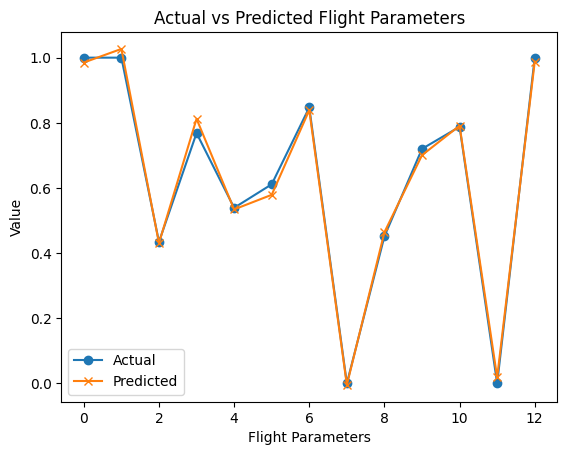

In [ ]:
import matplotlib.pyplot as plt

# Select a sample index (e.g., first test sample)
sample_idx = 188
sample_idx = 18
# Plot actual vs predicted for the first feature
plt.plot(y_test[sample_idx], label="Actual", marker='o')
plt.plot(y_pred[sample_idx], label="Predicted", marker='x')
plt.xlabel("Flight Parameters")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs Predicted Flight Parameters")
plt.show()


In [ ]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


residuals

In [ ]:
import numpy as np

residuals = np.abs(y_test - y_pred)  # Absolute difference


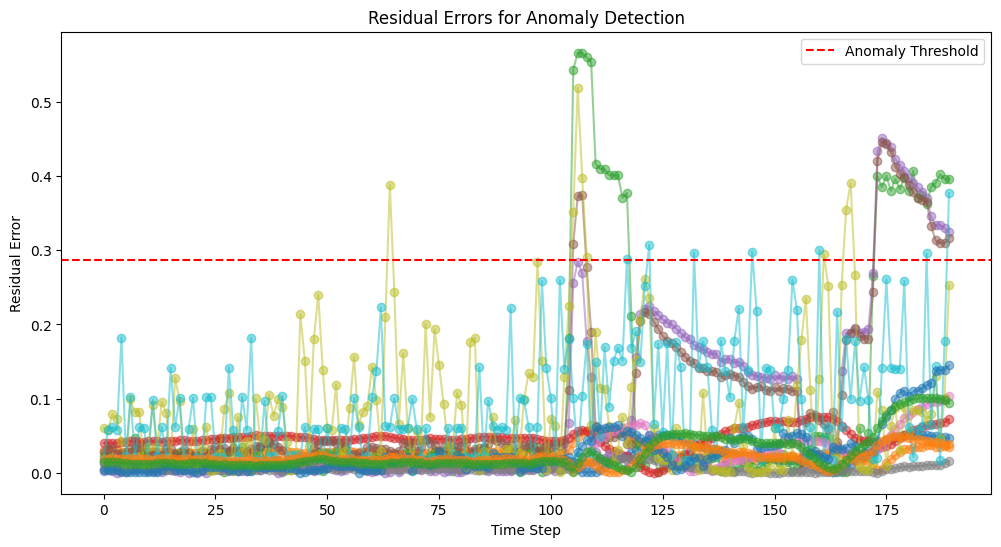

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', alpha=0.5)  # Scatter plot
plt.axhline(y=np.mean(residuals) + 3*np.std(residuals), color='r', linestyle='--', label="Anomaly Threshold")
plt.xlabel("Time Step")
plt.ylabel("Residual Error")
plt.title("Residual Errors for Anomaly Detection")
plt.legend()
plt.show()


In [ ]:
threshold = np.mean(residuals) + 3 * np.std(residuals)
anomalies = np.where(residuals > threshold)

print("Anomalous points:", anomalies)


Anomalous points: (array([ 64, 105, 105, 105, 106, 106, 106, 107, 107, 107, 108, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 117, 122, 132, 145, 160,
       161, 166, 167, 173, 173, 173, 174, 174, 174, 175, 175, 175, 176,
       176, 176, 177, 177, 177, 178, 178, 178, 179, 179, 179, 180, 180,
       180, 181, 181, 181, 182, 182, 182, 183, 183, 183, 184, 184, 184,
       184, 185, 185, 185, 186, 186, 186, 187, 187, 187, 188, 188, 188,
       189, 189, 189, 189]), array([8, 2, 5, 8, 2, 5, 8, 2, 5, 8, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9,
       9, 9, 9, 9, 8, 8, 8, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5,
       2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 9,
       2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 9]))


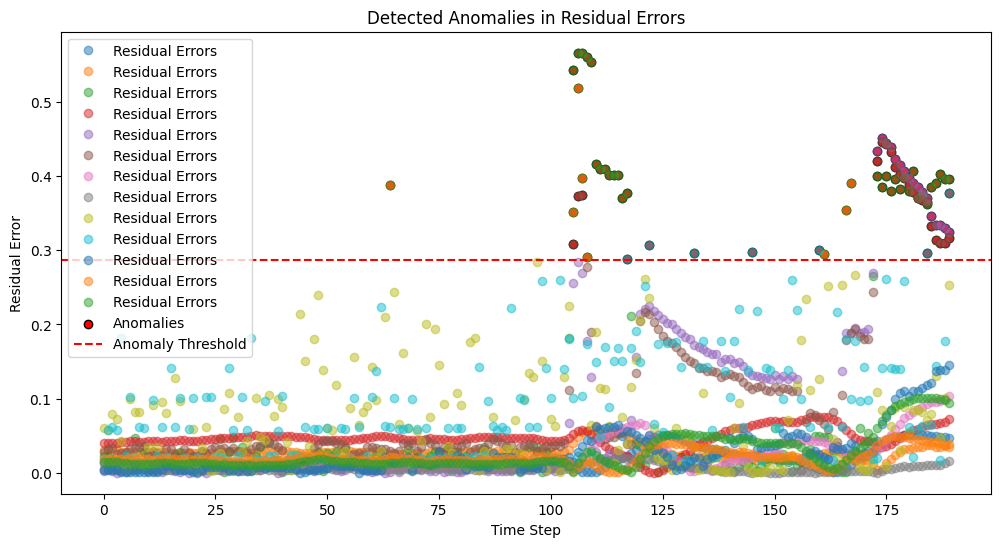

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='', alpha=0.5, label="Residual Errors")  # Scatter plot

# Highlight anomalies
plt.scatter(anomalies[0], residuals[anomalies], color='red', label="Anomalies", edgecolors='k')

plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.xlabel("Time Step")
plt.ylabel("Residual Error")
plt.title("Detected Anomalies in Residual Errors")
plt.legend()
plt.show()


##testing

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/trained_lstm_model.h5", compile=False)
print(model.summary())  # Check if the model is loaded correctly


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 13)                  │             663 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,663 (131.50 KB)

 Trainable params: 33,663 (131.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Convert DataFrame to NumPy array
new_flight_data = new_flight_data.to_numpy()

# Reshape the data
new_flight_data = new_flight_data.reshape(-1, sequence_length, num_features)

# Make predictions
predictions = model.predict(new_flight_data)



1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


In [ ]:
residual_errors = np.abs(y_test - y_pred)

In [ ]:
threshold = np.mean(residual_errors) + 3 * np.std(residual_errors)

In [ ]:
anomalies = np.where(residual_errors > threshold)
print("Anomalous points:", anomalies)

Anomalous points: (array([ 64, 105, 105, 105, 106, 106, 106, 107, 107, 107, 108, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 117, 122, 132, 145, 160,
       161, 166, 167, 173, 173, 173, 174, 174, 174, 175, 175, 175, 176,
       176, 176, 177, 177, 177, 178, 178, 178, 179, 179, 179, 180, 180,
       180, 181, 181, 181, 182, 182, 182, 183, 183, 183, 184, 184, 184,
       184, 185, 185, 185, 186, 186, 186, 187, 187, 187, 188, 188, 188,
       189, 189, 189, 189]), array([8, 2, 5, 8, 2, 5, 8, 2, 5, 8, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9,
       9, 9, 9, 9, 8, 8, 8, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5,
       2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 9,
       2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 2, 4, 5, 9]))


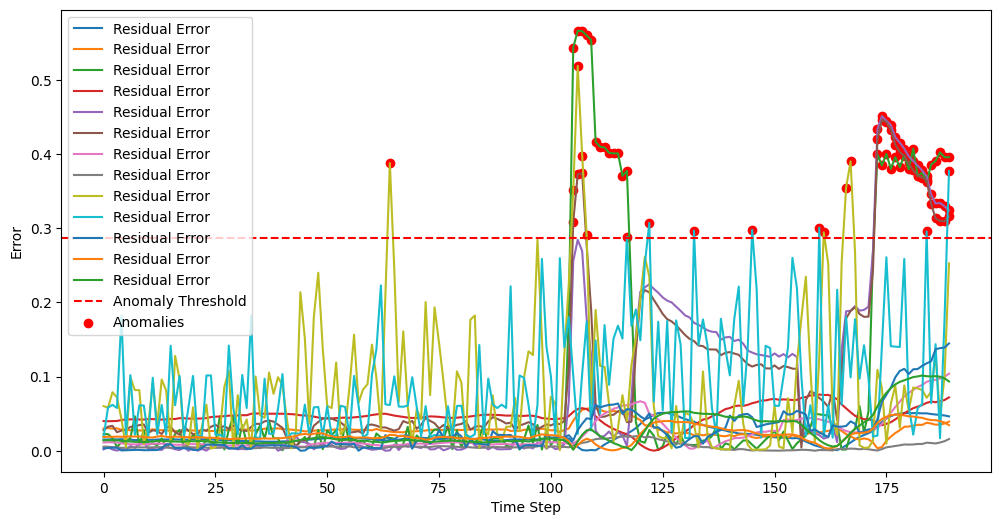

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(residual_errors, label="Residual Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.scatter(anomalies[0], residual_errors[anomalies], color='red', label="Anomalies")
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.legend()
plt.show()


##Flask

In [ ]:
!pip install flask flask_cors scipy pyngrok

In [ ]:
!ngrok authtoken 2uWpt9XWUJ1uX90BUSlS7fMEqLY_6HgvF3tWhPxHBBVnNbUzx

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os

UPLOAD_FOLDER = "/content/uploads"

# Check if the upload folder exists and list its files
if os.path.exists(UPLOAD_FOLDER):
    print("Uploaded files:", os.listdir(UPLOAD_FOLDER))
else:
    print("Upload folder does not exist!")



Upload folder does not exist!


In [ ]:
pip install flask-cors


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import os
from werkzeug.utils import secure_filename
from pyngrok import ngrok  # To expose Colab server

app = Flask(__name__)
CORS(app, resources={r"/*": {"origins": "*"}})


UPLOAD_FOLDER = "/content/uploads"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

@app.route("/upload", methods=["POST"])
def upload_file():
    if "file" not in request.files:
        return jsonify({"message": "No file uploaded"}), 400

    file = request.files["file"]
    filename = secure_filename(file.filename)
    file_path = os.path.join(UPLOAD_FOLDER, filename)
    file.save(file_path)

    return jsonify({"message": f"{filename} uploaded successfully!", "path": file_path})

# Start Flask app
port = 5000
public_url = ngrok.connect(port).public_url  # Get public URL
print(f"Public URL: {public_url}")

app.run(port=5000)


Public URL: https://0857-34-143-157-60.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [20/Mar/2025 11:59:39] "POST / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2025 11:59:39] "POST / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2025 11:59:39] "POST / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2025 11:59:39] "POST / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2025 11:59:40] "POST / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2025 11:59:40] "POST / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Mar/2025 12:00:15] "POST / HTTP/1.1" 404 -


In [ ]:
import os
print("Uploaded files:", os.listdir("/content/uploads"))

Uploaded files: []


In [ ]:
!cat /content/uploads/*


cat: '/content/uploads/*': No such file or directory


In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/upload', methods=['POST'])
def upload():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'}), 400
    file = request.files['file']
    return jsonify({'filename': file.filename, 'status': 'Uploaded successfully'})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
